In [3]:
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from utils import setup_plotting_standards, plotTree, plotPoints, hpd, basic_formatting
import baltic as bt
import numpy as np
from scipy.stats import gaussian_kde


setup_plotting_standards()
COLOR = '#343434'

color_map = {
    "Zambia" : "#009E73", # green
    "Mozambique" : "#56B4E9", # blue
    "Nigeria" : "#0072B2",  # reddish-purple
    "Cameroon" : "#D55E00", # brown 
    "Democratic Republic of the Congo" : COLOR, #Black
    "Uganda" : "#F0E442",
    "Malawi" : "#E69F00", # orange 
    "Other" : "#C8C8C8" # grey
}

def plot_distribution( ax, data, xloc, width, edgecolor=COLOR, color=COLOR, alpha=0.2 ):
    hpdHi, hpdLo = hpd( data, 0.95 )
    y_grid = np.linspace( hpdLo, hpdHi, 101 )
    
    kde = gaussian_kde( data )
    x_grid = kde.evaluate( y_grid )
    x_grid = x_grid / x_grid.max() * width
    
    ax.plot( [xloc+x for x in x_grid], y_grid, color=edgecolor, lw=1, zorder=101, solid_capstyle="round" )
    ax.plot( [xloc-x for x in x_grid], y_grid, color=edgecolor, lw=1, zorder=101, solid_capstyle="round" )
    
    ax.fill_betweenx( y_grid, [xloc+x for x in x_grid], [xloc-x for x in x_grid], color=color, edgecolor='none', alpha=alpha, zorder=100 )

# Figure 2A: MCC Tree
Here we visualize the MCC tree from our Bayesian phylogenetic reconstruction.

First, we load the tree from file. I use baltic (H/t to @evogytis) because dendropy tends to mangle the tree otherwise. Tree was generated using TreeAnnotator, after discarding the burn-in.

In [6]:
tree = bt.loadNexus( "../beast-analyses/2024-08-06_constant_relaxed.mcc.tree" )
tree.treeStats()


Tree height: 55.498287
Tree length: 4025.387818
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5071 (2535 nodes and 2536 leaves)


Next, we load the metadata as we'll use it to color the tree.

In [22]:
md = list()
for file in ["supplemental_data1.csv", "supplemental_data2.csv"]:
    df = pd.read_csv( "../data/" + file, usecols=["taxa", "country", "te"] )
    df["workshop"] = (file == "supplemental_data1.csv")
    md.append( df )
    
md = pd.concat( md )
md = md.drop_duplicates()
md = md.set_index( "taxa" )
md.head()

,country,te,workshop
taxa,,,
Africa|CMR|CMR_CEN005NA35|T12|2023-04-12,Cameroon,T12,True
Africa|CMR|CMR_CEN032BM-B48|T12|2023-05-04,Cameroon,T12,True
Africa|CMR|CMR_E05557442|T12|2023-05-12,Cameroon,T12,True
Africa|CMR|CMR_CEN030DA43|T12|2023-05-03,Cameroon,T12,True
Africa|CMR|CMR_CEN027NV44|T12|2023-05-01,Cameroon,T12,True


We'll also label two putative introduction of T15 into Africa. We identified the members by manually inspecting the tree, and here we load in the list of members.

In [4]:
members = dict()
with open( "../data/t15_members.txt", "r" ) as members_file:
	for line in members_file:
		if line.strip() == "":
			continue
		elif line.startswith( ">" ):
			group = line.strip().replace( ">", "" )
			members[group] = []
		else:
			members[group].append( line.strip() )

for i in members:
	print( f"{i} - {len( members[i] )} members")
    

Small - 8 members
Large - 322 members


Next, we load the posterior estimates of the introduction dates of these two putative introductions. These were generated as part of the BEAST phylogenetic reconstruction.

In [8]:
tmrca = pd.read_csv( "../beast-analyses/2024-08-06_constant_relaxed.combined.log", sep="\t", usecols=["state", "age(T15a)", "age(T15b)"] )
#tmrca = tmrca.loc[tmrca["state"]>50000000]  # Remove burnin.
tmrca.head()

,state,age(T15a),age(T15b)
50001,50001000,2019.993593,2022.580377
50002,50002000,2019.993676,2022.580412
50003,50003000,2019.993476,2022.070190
50004,50004000,2019.993404,2022.070151
50005,50005000,2019.993693,2022.169124


Finally, we plot the MCC tree. We label taxa by their collection_location, filling or not filling the point based on whether the genome was collected by CholGEN or not. We also indicate the MRCA of the T15 introductions and use an inset to show the distributions of the TMRCAs.

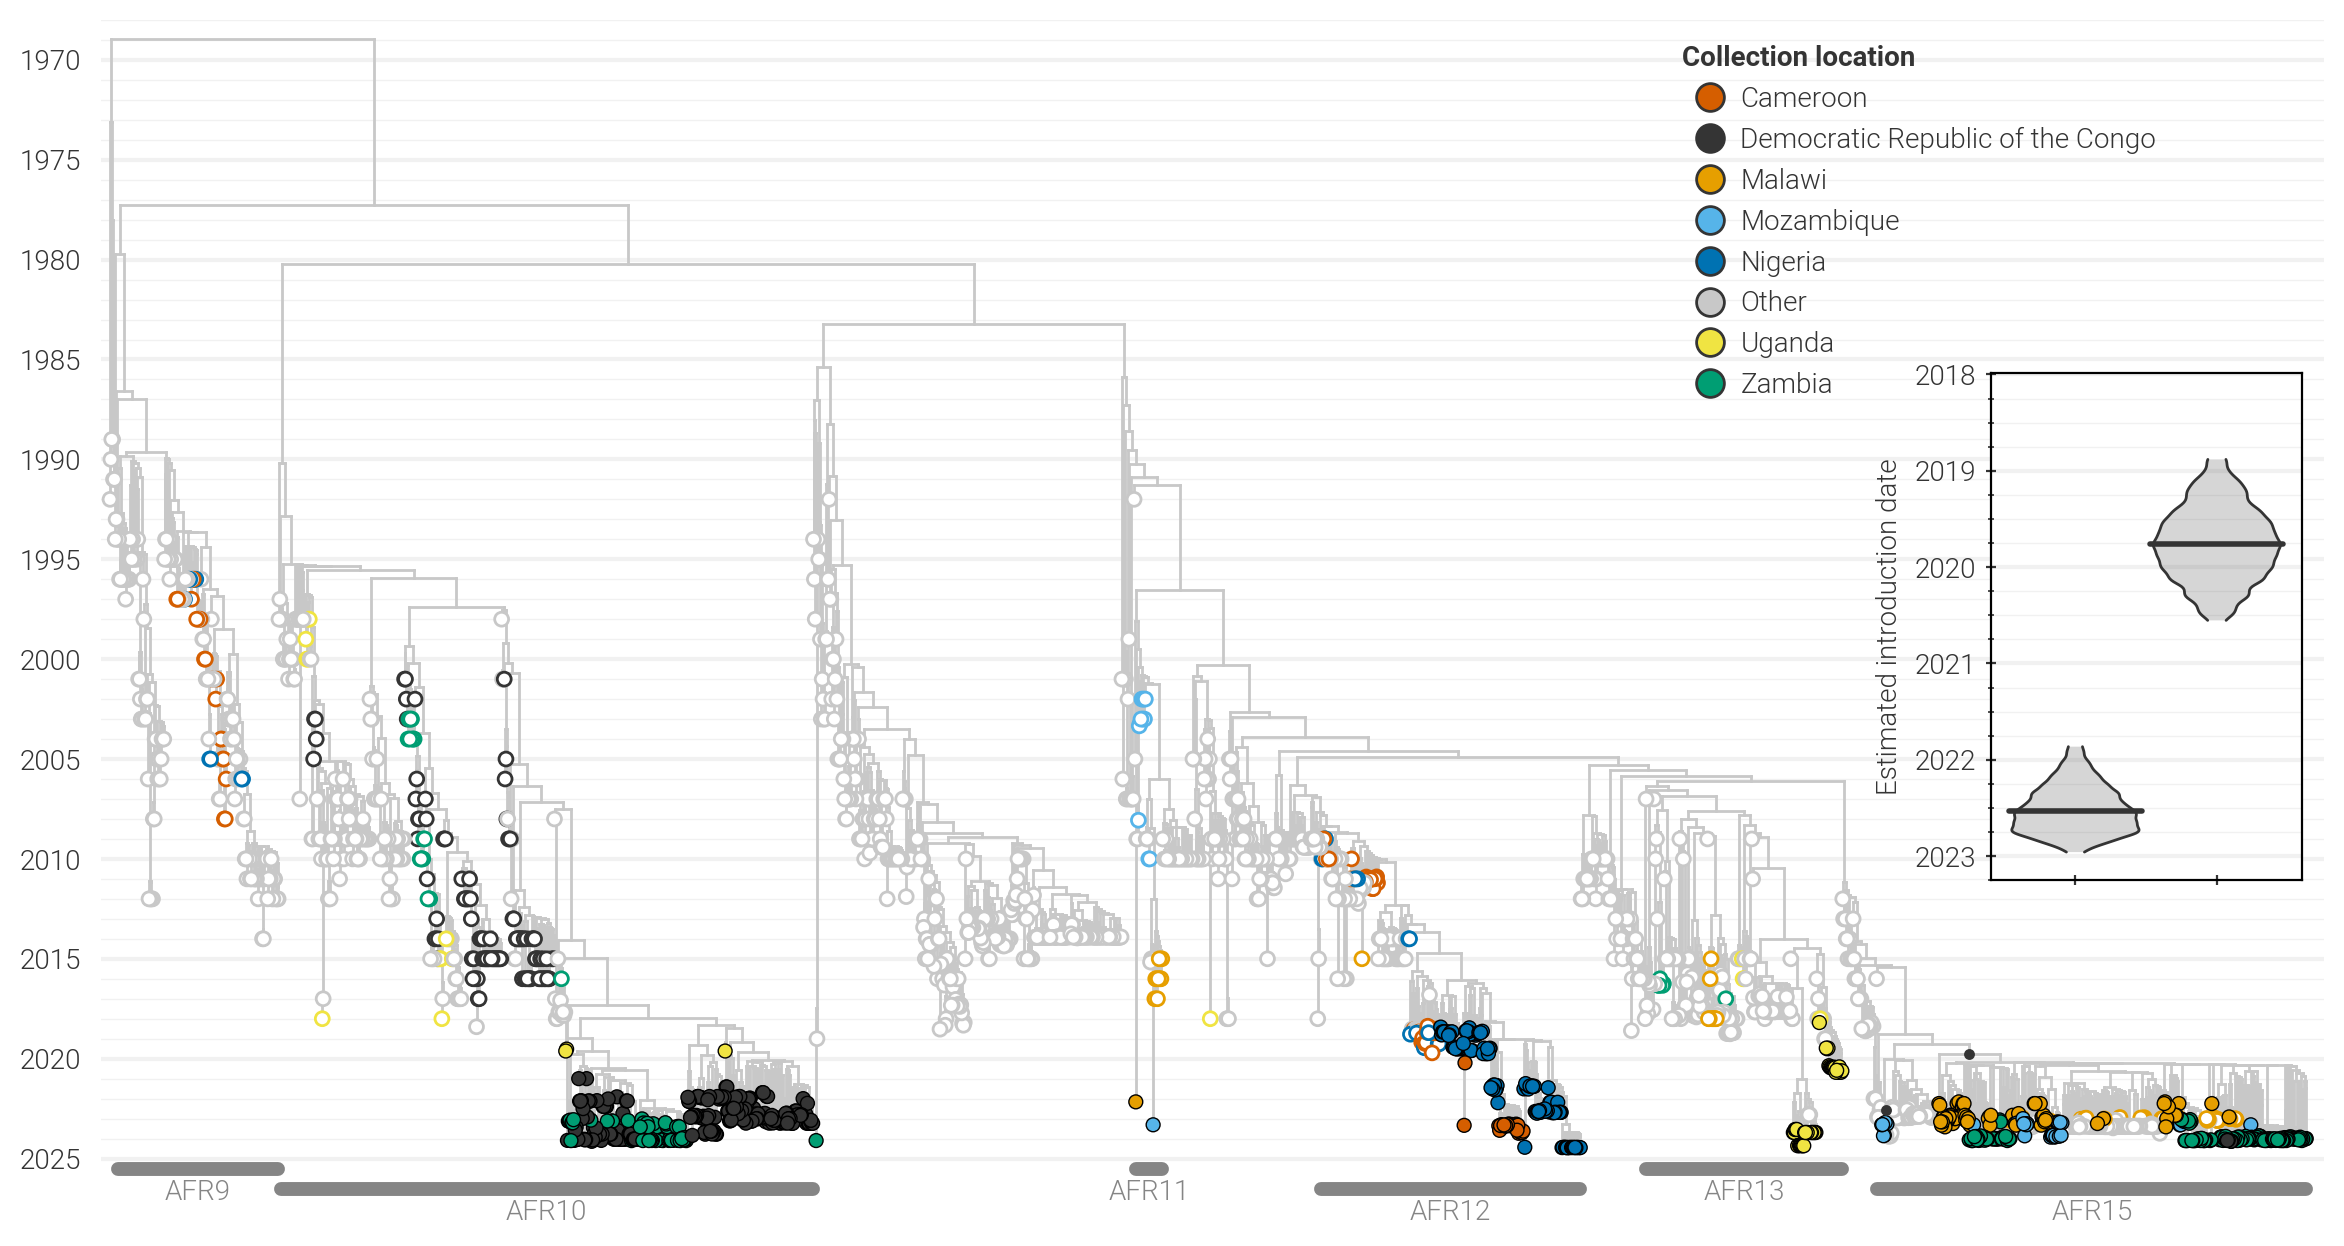

In [9]:
def color_func( label ):
    country = md.loc[label,"country"]
    return color_map.get( country, color_map["Other"] )

def is_workshop( node, inverse=False ):
    if node.is_leaf():
        if inverse:
            return not md.loc[node.name, "workshop"]
        return md.loc[node.name, "workshop"]
    return False

fig, ax = plt.subplots( dpi=200, figsize=(12,6.5) )
x_attr = lambda k: k.absoluteTime
node_func = lambda k: color_func( k.name )
c_func = lambda k: color_map["Other"]
plotTree( tree, ax, x_attr=x_attr, colour=color_map["Other"], linewidth=1, horizontal=True )
plotPoints( tree, ax, x_attr=x_attr, target=lambda x: is_workshop(x, inverse=True), size=25, colour="w", outline_colour=node_func, outline_size=40, zorder=100, horizontal=True, style="nate", linewidth=1 ) # Option 4
plotPoints( tree, ax, x_attr=x_attr, target=is_workshop, size=25, colour=node_func, zorder=150, horizontal=True, style="nate", linewidth=0.5 ) # Option 4
#plotPoints( tree, ax, x_attr=x_attr, target=lambda k : k.is_node() & (k.traits.get( "posterior", 0) > 0.5), color=COLOR, size=2, horizontal=True )

ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params( axis="y", left=False, right=False, which="both", labelbottom=True, labelsize=10 )
ax.set_xlim(-20,tree.ySpan+10)

ax.set_yticks( range( 1965, 2030, 5 ), minor=False )
ax.set_yticks( range( 1965, 2026 ), minor=True )
ax.set_ylim( 1968, 2027 )

ax.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
ax.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )

[ax.spines[loc].set_visible(False) for loc in ax.spines]

legend2 = [
    Line2D([0], [0], linestyle='none', marker='o', color=color_map[country], markeredgecolor=COLOR, markeredgewidth=1, label=country, markersize=10 ) for country in sorted( color_map.keys() ) 
]

legend2 = ax.legend( title="Collection location", handles=legend2, loc="upper left", handletextpad=0.1, frameon=False, fontsize=10, alignment="left", title_fontproperties={ "size" : 10, "weight" : "bold" }, bbox_to_anchor = (0.7,0,1,1) )

count = 0
for lin in ["T9", "T10", "T11", "T12", "T13", "T15"]:
    representatives = md.loc[md["te"]==lin].index.to_list()
    span = [tip.y for tip in tree.getExternal() if tip.name in representatives]
    min_span = min( span )
    max_span = max( span )
##    span = sorted( [tip.y for tip in tree.getExternal( lambda x: x.name in lineage_dict[lin] )] )
    yloc = 2025.5 + 1 * (count % 2)
    ax.hlines( yloc, min_span, max_span, colors=COLOR, alpha=0.6, linewidth=5, capstyle="round", label=lin )
    ax.text( (min_span + max_span) / 2, yloc+1.2, lin.replace( "T", "AFR" ), ha="center", va="center", fontsize=10, alpha=0.6 )
    
    count += 1

small_members = [i for i in tree.Objects if i.is_leaf() and i.name in members["Small"]]
small_mrca = tree.commonAncestor( small_members )
small_tmrca = small_mrca.absoluteTime
# Alternatively: #8B4513
ax.scatter( [small_mrca.y], [small_tmrca], marker="o", color=COLOR, s=10, zorder=200, edgecolor=COLOR, linewidth=0.75, )

large_members = [i for i in tree.Objects if i.is_leaf() and i.name in members["Large"]]
large_mrca = tree.commonAncestor( large_members )
large_tmrca = large_mrca.absoluteTime
# Alternatively: #8B4513
ax.scatter( [large_mrca.y], [large_tmrca], marker="o", color=COLOR, s=10, zorder=200, edgecolor=COLOR, linewidth=0.75 )

#ax.add_patch(Rectangle( (550,2022),50, 2.9, fill=False, facecolor="grey", edgecolor=COLOR, linewidth=1.25, linestyle="dashed", zorder=50, alpha=0.75 ) )
#ax.text( 735,2023.5, "+IncA/C", va="center", color=COLOR, alpha=0.9, fontsize=11)
ax.invert_yaxis()
ax.invert_xaxis()

axins = ax.inset_axes(
    [0.85, 0.27, 0.14, 0.43] )
plot_distribution( axins, tmrca["age(T15a)"], 1, 0.45 )
plot_distribution( axins, tmrca["age(T15b)"], 0, 0.45 )
lns = axins.hlines( 
    [tmrca["age(T15b)"].median(), tmrca["age(T15a)"].median()], 
    xmin=[-0.47,0.53], xmax=[0.47,1.47], color=COLOR, linewidth=2, 
)
lns.set_capstyle( "round" )
axins.set_yticks( range( 2018,2024 ) )
axins.set_yticks( np.arange( 2018,2024,0.25), minor=True )
axins.set_xticks( [0,1], [], rotation=30, ha="right" )

basic_formatting( axins, spines=["left", "right", "bottom", "top"], ylabel="Estimated introduction date", xlims=(-0.6, 1.6), ylims=(2017.99,2023.25), xsize=10, ysize=10 )

axins.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
axins.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )

#axins.axvspan( 0.5,1.5, color="black", alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )
axins.invert_yaxis()

plt.tight_layout()
fig.savefig( "plots/figure2-mcc-tree.pdf" )
plt.show()